## 2D Protein Folding

Implementation of a simple 2D protein folding algorithm based on the hydrophobicity of amino acids.

* A protein with spatial information is represented by a tuple of two strings of the same length. The first string contains symbols of the amino acids in the protein, and the second string has symbols from {I, N, S, E, W}, representing the protein structure by the relative position of each amino acid to the previous one (North, South, East, West), where 'I' is reserved for the initial amino acid.

* If there are spatial overlaps, the structure is considered invalid, for example: ('PEPTIDE', 'IEENWWS').

* The protein structure will be scored based on the hydrophobicity of amino acids and the elements adjacent to each amino acid (explained later).

* It is an optimization problem to be solved using the Simulated Annealing algorithm.

Given a protein with spatial information, we will construct a dictionary that represents the information in a way that facilitates analysis. The keys of this dictionary will be tuples of two integers representing spatial coordinates, and the values will be amino acid letters. The first amino acid will always be placed at coordinates (0,0), and the subsequent ones will be placed according to their relative positions. For example, the protein ('PEPTIDE','IEENNWS') will result in the following dictionary:

{(0,0): 'P', (1,0): 'E', (2,0): 'P', (2,1): 'T', (2,2): 'I',
 (1,2): 'D', (1,1): 'E'}
 

In [1]:
def get_spatial_dic(protein,structure):
    """It takes as input the protein and its structure and returns the dictionary of coordinates."""
    dic = {}
    x, y = 0, 0
    for p in zip(protein, structure):
        if p[1]=='E':
            x+=1
        elif p[1]=='W':
            x-=1
        elif p[1]=='N':
            y+=1
        elif p[1]=='S':
            y-=1

        # If an spatial overlap exists, return an empty dictionary
        if (x,y) in dic:
            return {}
        
        # Store the aminoacid
        dic[(x,y)] = p[0]
        
    return dic



In [2]:
# Testing
print(get_spatial_dic('PEPTIDE','IEENNWS'))
# {(0, 0): 'P', (1, 0): 'E', (2, 0): 'P', (2, 1): 'T', (2, 2): 'I', (1, 2): 'D', (1, 1): 'E'}
print(get_spatial_dic('PEPTIDE','IEENWWS'))
# {}

{(0, 0): 'P', (1, 0): 'E', (2, 0): 'P', (2, 1): 'T', (2, 2): 'I', (1, 2): 'D', (1, 1): 'E'}
{}


Amino acids can be classified based on their solubility as follows:

* Hydrophilic: polar amino acids with a tendency to associate with water.
* Hydrophobic: nonpolar amino acids with a tendency to repel water.

The solubility of amino acids is measured by calculating the change in Free Energy in contact with water at pH = 7.

Hydropathy is defined as the change in Free Energy (ΔG) associated with the transfer of amino acids from an organic solution to an aqueous one.

Below is a dictionary with the 20 amino acids and their corresponding values of the change in Free Energy:

In [3]:
aa_deltaG = {
 'A': 1,    # Alanine
 'C': 0.17, # Cysteine
 'D': -3,   # Aspartic Acid
 'E': -2.6, # Glutamic Acid
 'F': 2.5,  # Phenylalanine
 'G': 0.67, # Glycine
 'H': -1.7, # Histidine
 'I': 3.1,  # Isoleucine
 'K': -4.6, # Lysine
 'L': 2.2,  # Leucine
 'M': 1.1,  # Methionine
 'N': -2.7, # Asparagine
 'P': -0.29,# Proline
 'Q': -2.9, # Glutamine
 'R': -7.5, # Arginine
 'S': -1.1, # Serine
 'T': -0.75,# Threonine
 'V': 2.3,  # Valine
 'W': 1.5,  # Tryptophan
 'Y': 0.08  # Tyrosine
} 

We will implement a function that, given an aminoacid, returns True if its ΔG is over -1.5 and False otherwise.

In [4]:
def is_hydrophobic(aa):
    """It takes an aminoacid as input and returns True if this is hydrophobic, and False otherwise."""
    return (aa_deltaG[aa] > -1.5)

Each amino acid has four neighboring positions (N, S, E, W), and if any of these positions is unoccupied by another amino acid, it is considered a free position occupied by the aqueous medium.

The score of an amino acid is calculated as follows:

* ΔG * N if the amino acid is not hydrophobic.
* ΔG * N + 10 * N if the amino acid is hydrophobic.

Here, N represents the number of adjacent free positions. The overall score of the protein is the sum of the scores of its amino acids. The objective is to minimize this score, indicating a better arrangement of hydrophilic amino acids in contact with the aqueous medium.

In [5]:
def get_score(dic):
    """It takes a dictionary representing the protein spatial structure and returns its score."""
    score = 0
    # Iterate over each element in dictionary
    for (x,y) in dic:
        n = 0 # Free adjacent positions counter
        # Iterate over adjacent positions
        for pos in [(x-1,y),(x+1,y),(x,y-1),(x,y+1)]:
            if pos not in dic:
                n += 1
        # Compute base score for the aminoacid
        amin = dic[(x,y)]
        score += aa_deltaG[amin]*n
        if is_hydrophobic(amin):
            score += 10*n
            
    return score

We can perform two different folding operations (90 or -90 degrees) for a protein structure based on a specified position i. The transformations for each angle are as follows:

* For 90 degrees:
    - N -> W
    - S -> E
    - E -> N
    - W -> S
    

* For -90 degrees:
    - N -> E
    - S -> W
    - E -> S
    - W -> N
    
We will implement a function, fold(structure, pos, angle), which takes a structure, a folding position (starting from 0), and an angle (either 90 or -90), and returns a new structure after applying the folding operation.

In [6]:
def fold(structure,pos,angle):
    # Dictionary as conversion table
    dic = {('N',90):'W',
           ('S',90):'E',
           ('E',90):'N',
           ('W',90):'S',
           ('N',-90):'E',
           ('S',-90):'W',
           ('E',-90):'S',
           ('W',-90):'N'}
    # Keep the structure until the folding position
    res = structure[0:pos]
    for i in range(pos,len(structure)):
        # Add the corresponding structure transformation
        res += dic[(structure[i],angle)]
    return res

In [7]:
# Testing
print(fold('IEEEEEE',4,90))
# IEEENNN

print(fold('IEEEEEE',4,-90))
# IEEESSS

print(fold('IEENNWS',4,-90))
# IEENENW

print(fold('IEENNWS',5,-90))
# IEENNNW

IEEENNN
IEEESSS
IEENENW
IEENNNW


We will implement a function get_successors(protein, structure) that, given a protein and its structure, returns a dictionary. The keys of this dictionary should be the possible valid structures after applying all possible foldings, and the values should be the corresponding spatial dictionaries obtained with get_spatial_dic. To obtain all possible foldings, we need to iterate over positions from 1 to the end of the structure. For each position, we will apply foldings at 90 and -90 degrees, then check if the spatial dictionary has data (is valid) before adding it to the result.

In [8]:
def get_successors(protein,structure):
    res = {}
    # Iterate over the protein structure
    for i in range(1,len(structure)):
        # Check the two possible transformations
        for a in [-90,90]:
            candidate = fold(structure,i,a)
            # Check if there is an spatial overlap
            dic = get_spatial_dic(protein,candidate)
            if dic != {}:
                res[candidate] = dic
                
    return res

We will use an implementation of the Simulating Annealing algorithm to solve the 2d folding protein as an optimization problem.

In [9]:
import random
-90+random.randint(0,2)*180

-90

In [10]:
import random
from math import e
def simulating_annealing(protein, tInit = 100, factor = 0.95, 
                         nCoolings = 100, nIters = 100):
    temperature = tInit
    currentState = (protein, 'I'+'E'*(len(protein)-1))
    currentScore = get_score(get_spatial_dic(*currentState))
    bestState = currentState
    bestScore = currentScore
    for i in range(0,nCoolings):
        print('Temperature ',temperature,' Best score: ',bestScore)
        for j in range(0,nIters):
            candidate = fold(currentState[1],
                             random.randint(1,len(protein)),
                             -90+random.randint(0,1)*180)
            dic = get_spatial_dic(protein,candidate)
            while (len(dic)==0):
                candidate = fold(currentState[1],
                             random.randint(1,len(protein)),
                             -90+random.randint(0,1)*180)
                dic = get_spatial_dic(protein,candidate)
            candidateScore = get_score(dic)
            scoreDiff = candidateScore - currentScore
            if scoreDiff < 0:
                candidateProb = 1.0
            else:
                candidateProb = e**(-scoreDiff/temperature)
            if random.random()<candidateProb:
                currentState = (protein,candidate)
                currentScore = candidateScore
                if currentScore < bestScore:
                    bestState = currentState
                    bestScore = currentScore
        temperature*= factor
    return bestState    

# Testing with different olfatory receptor proteins

## Olfactory receptor 14C36 (Human)
Accession Number Uniprot: Q8NHC7


In [11]:
Q8NHC7='MPNSTTVMEFLLMRFSDVWTLQILHSASFFMLYLVTLMGNILIVTVTTCDSSLHMPMYFFLRNLSILDACYISVTVPTSCVNSLLDSTTISKAGCVAQVFLVVFFVYVELLFLTIMAHDRYVAVCQPLHYPVIVNSRICIQMTLASLLSGLVYAGMHTGSTFQLPFCRSNVIHQFFCDIPSLLKLSCSDTFSNEVMIVVSALGVGGGCFIFIIRSYIHIFSTVLGFPRGADRTKAFSTCIPHILVVSVFLSSCSSVYLRPPAIPAATQDLILSGFYSIMPPLFNPIIYSLRNKQIKVAIKKIMKRIFYSENV'

result_Q8NHC7 = simulating_annealing(Q8NHC7,100,0.95,100,100)
result_Q8NHC7

Temperature  100  Best score:  5233.380000000001
Temperature  95.0  Best score:  4324.480000000001
Temperature  90.25  Best score:  4190.470000000002


Temperature  85.7375  Best score:  4089.8600000000024
Temperature  81.45062499999999  Best score:  3788.140000000001
Temperature  77.37809374999999  Best score:  3702.220000000001
Temperature  73.50918906249998  Best score:  3702.220000000001
Temperature  69.83372960937498  Best score:  3374.26
Temperature  66.34204312890623  Best score:  3305.920000000001
Temperature  63.02494097246091  Best score:  3305.920000000001
Temperature  59.87369392383786  Best score:  3305.920000000001
Temperature  56.880009227645964  Best score:  3305.920000000001
Temperature  54.03600876626366  Best score:  3305.920000000001
Temperature  51.33420832795048  Best score:  3305.920000000001
Temperature  48.76749791155295  Best score:  3305.920000000001
Temperature  46.3291230159753  Best score:  3171.359999999999
Temperature  44.012666865176534  Best score:  3171.359999999999
Temperature  41.812033521917705  Best score:  3171.359999999999
Temperature  39.72143184582182  Best score:  3171.359999999999
Temperatu

('MPNSTTVMEFLLMRFSDVWTLQILHSASFFMLYLVTLMGNILIVTVTTCDSSLHMPMYFFLRNLSILDACYISVTVPTSCVNSLLDSTTISKAGCVAQVFLVVFFVYVELLFLTIMAHDRYVAVCQPLHYPVIVNSRICIQMTLASLLSGLVYAGMHTGSTFQLPFCRSNVIHQFFCDIPSLLKLSCSDTFSNEVMIVVSALGVGGGCFIFIIRSYIHIFSTVLGFPRGADRTKAFSTCIPHILVVSVFLSSCSSVYLRPPAIPAATQDLILSGFYSIMPPLFNPIIYSLRNKQIKVAIKKIMKRIFYSENV',
 'IWWNEENWNWSWWNENEEESEESESEENWNWNEESENENESENNNENWWNWWWSEESWSSWNWSWWSWNNNNNWSWWNNNNNENNEEESESESWWNWSWWSSENEESEENENESENENWWWNENWNEEENWWNENESENESSWSESESENNWNNNESSEESWSSENESSESWWSESWSEESWWWNWNNNWNWNWSSSEESWWSEESSSSESENESESWSWNWSWNNWSSSEESESWWNWSWSESWWWSSENESENESENESENENNNNESSSENNNNWWNENENNWNENNNNENEEESWSSWWSSSSEESWW')

The following function plots a representation of the 2D protein structure

In [12]:
from matplotlib import pyplot

def representation(result):
    dic = get_spatial_dic(*result)
    for (a,b) in dic:
        if is_hydrophobic(dic[(a,b)]):
            pyplot.plot(a,b,'bo')
        else:
            pyplot.plot(a,b,'go')



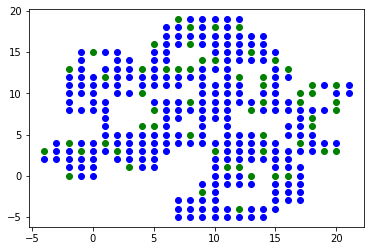

In [13]:
representation(result_Q8NHC7)

Modification of the parameters of the algorithm

In [14]:
result2_Q8NHC7 = simulating_annealing(Q8NHC7,150,0.99,250,250)
result2_Q8NHC7

Temperature  150  Best score:  5233.380000000001
Temperature  148.5  Best score:  4428.100000000003
Temperature  147.015  Best score:  3892.8000000000006
Temperature  145.54485  Best score:  3713.4500000000003
Temperature  144.0894015  Best score:  3713.4500000000003
Temperature  142.648507485  Best score:  3713.4500000000003


Temperature  141.22202241015  Best score:  3713.4500000000003
Temperature  139.8098021860485  Best score:  3713.4500000000003
Temperature  138.41170416418802  Best score:  3713.4500000000003
Temperature  137.02758712254615  Best score:  3667.240000000001
Temperature  135.6573112513207  Best score:  3667.240000000001
Temperature  134.30073813880747  Best score:  3667.240000000001
Temperature  132.9577307574194  Best score:  3667.240000000001
Temperature  131.6281534498452  Best score:  3667.240000000001
Temperature  130.31187191534676  Best score:  3667.240000000001
Temperature  129.00875319619328  Best score:  3667.240000000001
Temperature  127.71866566423135  Best score:  3667.240000000001
Temperature  126.44147900758904  Best score:  3667.240000000001
Temperature  125.17706421751315  Best score:  3667.240000000001
Temperature  123.92529357533802  Best score:  3667.240000000001
Temperature  122.68604063958463  Best score:  3667.240000000001
Temperature  121.45918023318879  Best score:

('MPNSTTVMEFLLMRFSDVWTLQILHSASFFMLYLVTLMGNILIVTVTTCDSSLHMPMYFFLRNLSILDACYISVTVPTSCVNSLLDSTTISKAGCVAQVFLVVFFVYVELLFLTIMAHDRYVAVCQPLHYPVIVNSRICIQMTLASLLSGLVYAGMHTGSTFQLPFCRSNVIHQFFCDIPSLLKLSCSDTFSNEVMIVVSALGVGGGCFIFIIRSYIHIFSTVLGFPRGADRTKAFSTCIPHILVVSVFLSSCSSVYLRPPAIPAATQDLILSGFYSIMPPLFNPIIYSLRNKQIKVAIKKIMKRIFYSENV',
 'IWWSWNWSWWWWSSENEESESSWNWWSESWSESWWWNWSSESENEEESSENNEENWWWNENENNEESWSSENENNNWWWNEENESENNEESEEEESWWWSEEEEESESWWNWWSSESSSEENENENNNEEEENENNWWNWWNENWNEESESSENESEESWSESWSEESWWSSSWNNNWWSSWWNNWSSSEEESWSESSWNWSSEEEESSWSSWSESWSSWNNNNNWWWNWWWNNNNENWWSWNNNNWNNNWSWSSWWWSWSESWSSEESWWWNNNWSSWSESSWNWNNWNWWSESESWWSEESESENESSWS')

In [15]:
result3_Q8NHC7 = simulating_annealing(Q8NHC7,50,0.8,50,50)
result3_Q8NHC7

Temperature  50  Best score:  5233.380000000001
Temperature  40.0  Best score:  4845.160000000001
Temperature  32.0  Best score:  4676.940000000001
Temperature  25.6  Best score:  4572.050000000004
Temperature  20.480000000000004  Best score:  4361.3700000000035
Temperature  16.384000000000004  Best score:  4128.510000000003
Temperature  13.107200000000004  Best score:  4055.200000000003
Temperature  10.485760000000004  Best score:  4017.8100000000036
Temperature  8.388608000000003  Best score:  3860.5600000000027
Temperature  6.710886400000003  Best score:  3641.730000000002
Temperature  5.368709120000003  Best score:  3624.580000000002
Temperature  4.294967296000002  Best score:  3593.820000000002
Temperature  3.435973836800002  Best score:  3518.4400000000023
Temperature  2.7487790694400016  Best score:  3395.810000000002
Temperature  2.1990232555520013  Best score:  3395.810000000002
Temperature  1.7592186044416012  Best score:  3395.810000000002
Temperature  1.407374883553281  Bes

('MPNSTTVMEFLLMRFSDVWTLQILHSASFFMLYLVTLMGNILIVTVTTCDSSLHMPMYFFLRNLSILDACYISVTVPTSCVNSLLDSTTISKAGCVAQVFLVVFFVYVELLFLTIMAHDRYVAVCQPLHYPVIVNSRICIQMTLASLLSGLVYAGMHTGSTFQLPFCRSNVIHQFFCDIPSLLKLSCSDTFSNEVMIVVSALGVGGGCFIFIIRSYIHIFSTVLGFPRGADRTKAFSTCIPHILVVSVFLSSCSSVYLRPPAIPAATQDLILSGFYSIMPPLFNPIIYSLRNKQIKVAIKKIMKRIFYSENV',
 'INWNENWWWWWSWSSEEESWWSEEESEENWNEENNENWNENNNWWSESWWNWNENWNNNWNENWWWWWSSSSSSSSSSWWSSSWWWWNNNNNNNNNNNNNNEEEEEEEEEENWWNWNNENWNWNNESESESENNWNNNEESENNESSENESSENESSWWSSWWNWWSSSEEEENESESSSSWSSWWSEESWSESSSSSSSSSSSSENNNNNNNNNNNEEEENNNWSWWNNNNNNNNNNNNNNNNNEESENNNENNNESEESSSSSSSSSWWNNNWWWWSSSSEEEEEEESSSSSSWWSWNNWNNNWSSWNWS')

## Olfactory receptor 51E2 (Mouse)
Accession Number Uniprot: Q8VBV9

In [16]:
Q8VBV9='MSSCNFTHATFLLIGIPGLEEAHFWFGFPLLSMYAVALFGNCIVVFIVRTERSLHAPMYLFLCMLAAIDLALSTSTMPKILALFWFDSREITFDACLAQMFFIHTLSAIESTILLAMAFDRYVAICHPLRHAAVLNNTVTVQIGMVALVRGSLFFFPLPLLIKRLAFCHSNVLSHSYCVHQDVMKLAYTDTLPNVVYGLTAILLVMGVDVMFISLSYFLIIRTVLQLPSKSERAKAFGTCVSHISVVLAFYVPLIGLSVVHRFGNSLDPIVHVLMGDVYLLLPPVINPIIYGAKTKQIRTRVLAMFKISCDKDIEAGGNT'

result_Q8VBV9 = simulating_annealing(Q8VBV9,150,0.99,250,250)
result_Q8VBV9

Temperature  150  Best score:  5283.790000000004
Temperature  148.5  Best score:  4394.590000000001
Temperature  147.015  Best score:  4171.7400000000025
Temperature  145.54485  Best score:  3995.960000000002
Temperature  144.0894015  Best score:  3968.8799999999997
Temperature  142.648507485  Best score:  3968.8799999999997
Temperature  141.22202241015  Best score:  3968.8799999999997
Temperature  139.8098021860485  Best score:  3968.8799999999997
Temperature  138.41170416418802  Best score:  3844.5700000000015
Temperature  137.02758712254615  Best score:  3807.310000000001
Temperature  135.6573112513207  Best score:  3807.310000000001
Temperature  134.30073813880747  Best score:  3807.310000000001
Temperature  132.9577307574194  Best score:  3807.310000000001
Temperature  131.6281534498452  Best score:  3807.310000000001
Temperature  130.31187191534676  Best score:  3807.310000000001
Temperature  129.00875319619328  Best score:  3807.310000000001
Temperature  127.71866566423135  Best

('MSSCNFTHATFLLIGIPGLEEAHFWFGFPLLSMYAVALFGNCIVVFIVRTERSLHAPMYLFLCMLAAIDLALSTSTMPKILALFWFDSREITFDACLAQMFFIHTLSAIESTILLAMAFDRYVAICHPLRHAAVLNNTVTVQIGMVALVRGSLFFFPLPLLIKRLAFCHSNVLSHSYCVHQDVMKLAYTDTLPNVVYGLTAILLVMGVDVMFISLSYFLIIRTVLQLPSKSERAKAFGTCVSHISVVLAFYVPLIGLSVVHRFGNSLDPIVHVLMGDVYLLLPPVINPIIYGAKTKQIRTRVLAMFKISCDKDIEAGGNT',
 'ISSESWSWNNNNWSWNNNNNWSSWWWWNWNEESEENWNWWWNWWSESWSSWSWWSSESWWNNNNENEENWWWSWSSWWSEESWSESWSEENESSESWSESWWNNWSSWWNWSSESSWWNWWSESSESWWWSEESEENNNNEEEENNWWNEEESENENENESSEENENNWSWNWWWNEENEEENWNEENNESSSWSESENNNEESWSSSSSSWNNNWSWSESWSEEEENNESSSSWWWNWSSSSESSSENNNNWNEESENENESSWSWWSSSENESSWWSSWNNWSSWNNWSSWWSSENEEEEESENNESSSESWSWNNWS')

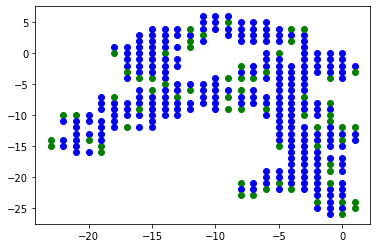

In [17]:
representation(result_Q8VBV9)

## Odorant receptor coreceptor (Drosophila)
Accession Number Uniprot: Q9VNB5

In [18]:
Q9VNB5='MTTSMQPSKYTGLVADLMPNIRAMKYSGLFMHNFTGGSAFMKKVYSSVHLVFLLMQFTFILVNMALNAEEVNELSGNTITTLFFTHCITKFIYLAVNQKNFYRTLNIWNQVNTHPLFAESDARYHSIALAKMRKLFFLVMLTTVASATAWTTITFFGDSVKMVVDHETNSSIPVEIPRLPIKSFYPWNASHGMFYMISFAFQIYYVLFSMIHSNLCDVMFCSWLIFACEQLQHLKGIMKPLMELSASLDTYRPNSAALFRSLSANSKSELIHNEEKDPGTDMDMSGIYSSKADWGAQFRAPSTLQSFGGNGGGGNGLVNGANPNGLTKKQEMMVRSAIKYWVERHKHVVRLVAAIGDTYGAALLLHMLTSTIKLTLLAYQATKINGVNVYAFTVVGYLGYALAQVFHFCIFGNRLIEESSSVMEAAYSCHWYDGSEEAKTFVQIVCQQCQKAMSISGAKFFTVSLDLFASVLGAVVTYFMVLVQLK'

result_Q9VNB5 = simulating_annealing(Q9VNB5,150,0.99,250,250)
result_Q9VNB5


Temperature  150  Best score:  7123.88000000001
Temperature  148.5  Best score:  6161.960000000009
Temperature  147.015  Best score:  6029.570000000008
Temperature  145.54485  Best score:  5511.07000000001
Temperature  144.0894015  Best score:  5444.660000000004
Temperature  142.648507485  Best score:  5372.770000000005
Temperature  141.22202241015  Best score:  5372.770000000005
Temperature  139.8098021860485  Best score:  5362.500000000009
Temperature  138.41170416418802  Best score:  5362.500000000009
Temperature  137.02758712254615  Best score:  5362.500000000009
Temperature  135.6573112513207  Best score:  5362.500000000009
Temperature  134.30073813880747  Best score:  5362.500000000009
Temperature  132.9577307574194  Best score:  5362.500000000009
Temperature  131.6281534498452  Best score:  5362.500000000009
Temperature  130.31187191534676  Best score:  5305.360000000007
Temperature  129.00875319619328  Best score:  5305.360000000007
Temperature  127.71866566423135  Best score: 

('MTTSMQPSKYTGLVADLMPNIRAMKYSGLFMHNFTGGSAFMKKVYSSVHLVFLLMQFTFILVNMALNAEEVNELSGNTITTLFFTHCITKFIYLAVNQKNFYRTLNIWNQVNTHPLFAESDARYHSIALAKMRKLFFLVMLTTVASATAWTTITFFGDSVKMVVDHETNSSIPVEIPRLPIKSFYPWNASHGMFYMISFAFQIYYVLFSMIHSNLCDVMFCSWLIFACEQLQHLKGIMKPLMELSASLDTYRPNSAALFRSLSANSKSELIHNEEKDPGTDMDMSGIYSSKADWGAQFRAPSTLQSFGGNGGGGNGLVNGANPNGLTKKQEMMVRSAIKYWVERHKHVVRLVAAIGDTYGAALLLHMLTSTIKLTLLAYQATKINGVNVYAFTVVGYLGYALAQVFHFCIFGNRLIEESSSVMEAAYSCHWYDGSEEAKTFVQIVCQQCQKAMSISGAKFFTVSLDLFASVLGAVVTYFMVLVQLK',
 'IESEESWWWNWNNENNWSWWNENWNEESEESSSESEEEESEENWNWWWWNWNENWNEESSSEENWNEEENNNENENNESSENNEESENNWWWWWNENWWWNNENWNENESSSSEEESWSEENNENNNNNNNEESWSSSSENNESSENENENNESSENNESSSWWSSWWWWWSSSWSSENENENWNEESENESESSWNWWSESSENESENENWNNNENESSSSENNNNEESWSSSESWWSEEEEEESWWSEESSWNWWNNWWSESSWSSSEENESSWSWSSSSESWWNNNNWSSWWNWSSEEESWWSEESENEESSEESSSSSEEENNESEESWWSEESENNEEEEENWNNWWSESWWNWNNNNWNWWSWWSWNNWSWNNEENNNWNEESSSSSENNNNESENENESESWWSSESESESWSEEENEENWNWNENWNWNNENWNWSSWNWNWSWNNENESEEENWNWNWSWWSWSSSSWNWNENWWSS')

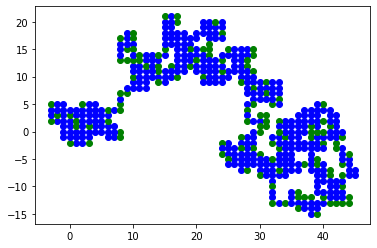

In [19]:
representation(result_Q9VNB5)

## Serpentine receptor class r-10 (C. elegans)
Accession Number Uniprot: Q18807

In [20]:
Q18807='MSGELWITLVDTADIVGVTLTFCVNIVLLGLLKTRGKNLGTYKYLMAFFSVFSIFYAIIEFILRPIMHIENTTFFLISRKRFNYSTKLGKINSAFYCACFATSFVVSGVHFVYRYFATCKPNLLRLFNLPTLLLWPLGCSVPVTMWASVSYFLYPDTEYTEAAVTNVLNNHYNWIKKENVSYIAYVYYQYENGVRHIYLKNLLGCFVHYFVMSMTFVVMFYCGYATWKTMNEHKDVSDRTRALQKQLFKALVLQTLIPTIFMYAPTGVMFIAPFFDVNLNANANFIVFCSFLYPGLDPLILILIIRDFRRTIFNFLCGKKNSVDESRSTTRANLSQVPT'

result_Q18807 = simulating_annealing(Q18807,150,0.99,250,250)
result_Q18807

Temperature  150  Best score:  5163.43
Temperature  148.5  Best score:  4247.890000000001
Temperature  147.015  Best score:  3953.050000000001
Temperature  145.54485  Best score:  3953.050000000001
Temperature  144.0894015  Best score:  3953.050000000001
Temperature  142.648507485  Best score:  3718.339999999998
Temperature  141.22202241015  Best score:  3718.339999999998
Temperature  139.8098021860485  Best score:  3718.339999999998
Temperature  138.41170416418802  Best score:  3718.339999999998
Temperature  137.02758712254615  Best score:  3718.339999999998
Temperature  135.6573112513207  Best score:  3718.339999999998
Temperature  134.30073813880747  Best score:  3718.339999999998
Temperature  132.9577307574194  Best score:  3718.339999999998
Temperature  131.6281534498452  Best score:  3718.339999999998
Temperature  130.31187191534676  Best score:  3718.339999999998
Temperature  129.00875319619328  Best score:  3718.339999999998
Temperature  127.71866566423135  Best score:  3718.33

('MSGELWITLVDTADIVGVTLTFCVNIVLLGLLKTRGKNLGTYKYLMAFFSVFSIFYAIIEFILRPIMHIENTTFFLISRKRFNYSTKLGKINSAFYCACFATSFVVSGVHFVYRYFATCKPNLLRLFNLPTLLLWPLGCSVPVTMWASVSYFLYPDTEYTEAAVTNVLNNHYNWIKKENVSYIAYVYYQYENGVRHIYLKNLLGCFVHYFVMSMTFVVMFYCGYATWKTMNEHKDVSDRTRALQKQLFKALVLQTLIPTIFMYAPTGVMFIAPFFDVNLNANANFIVFCSFLYPGLDPLILILIIRDFRRTIFNFLCGKKNSVDESRSTTRANLSQVPT',
 'ISEEENNWSWNWNNNESSEENWNNESESEENWNENWWWWNENWNEENWWWSSSWNWWNWSSWSEEEESWWSWNWSWNNWSSWNWSSSSWSSSENENESSWSEESWSWWWSEEEESWWWSSEESSWSWWSWWSWSWSESEENWNENESENNESESWSSEENESENENNWWSWNNWNEENNENEEEEESWSWWSSSENNEEEENWNENWNENNNNNESSSESWSSSSENENWNEEESSSENNNNWNNWSSWNNWNENWNWNENWWNNEESENNESSSWSSEEENEENWNWSWNNNNWWNEEESSSEEESESWSSSSSEEESSWNWWWNWNENNWSWWWSEE')

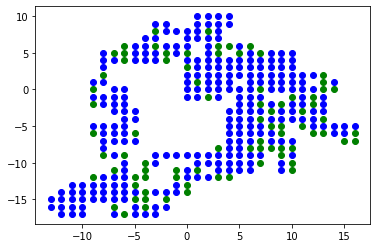

In [21]:
representation(result_Q18807)

Despite the limitations in representing a protein as a 2D structure, the results make sense, as in the representations of the structures, hydrophilic amino acids (green dots) are typically in contact with the aqueous medium (empty spaces), while more hydrophobic ones (blue dots) are usually situated in the interior and clustered together.

In [22]:
# Representation of the protein structure with a color gradient based on the aminoacid deltaG value.

from matplotlib import pyplot as plt

def gradient_representation(result):
    
    dic = get_spatial_dic(*result)
    x, y, deltaG = [], [], []
    # Store the positions and the deltaG values of each aminoacid
    for (a,b) in dic:
        x.append(a)
        y.append(b)
        deltaG.append(aa_deltaG[dic[(a,b)]])

    # Plot the structure with a color gradient
    plt.scatter(x,y, c=deltaG, cmap='PiYG')
    cbar = plt.colorbar()
    cbar.set_label('deltaG')


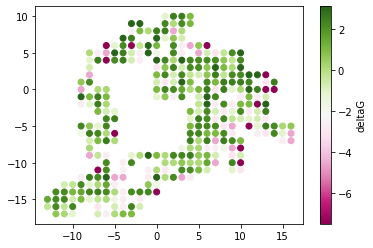

In [23]:
# C elegans
gradient_representation(result_Q18807)

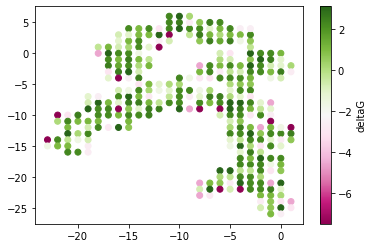

In [24]:
# Mouse
gradient_representation(result_Q8VBV9)